# Libor Curve Bootstrapper

The goal of the project is to build a bootstrapping procedure whose output will be a forward libor curve (an instance of the python class ForwardRateCurve) in the “multi-curve” framework. The input parameters to derive this curve are:

* The par rate of a set of Overnight Index Swaps (i.e. their market quotation)
* The fixing value of the libor rate at the “evaluation date”
* The par rate of a set of Swap (i.e. their market quotation), whose underlying libor rate has 6 months tenor (i.e. the floating leg pays every six months) and the fixed coupon is paid annually

The resulting class will be used to compute the forward libor rate at some future dates.

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

In [3]:
from datetime import date

In [4]:
today = date(2019, 10, 31)

In [5]:
libor_tenor = 6

In [6]:
libor_fixing_value = 0.00351

In [7]:
ois_quotes = [
    {'maturity': 1, 'rate': 0.00106},
    {'maturity': 2, 'rate': 0.00114},
    {'maturity': 3, 'rate': 0.00115},
    {'maturity': 4, 'rate': 0.00117},
    {'maturity': 5, 'rate': 0.00119},
    {'maturity': 6, 'rate': 0.00121},
    {'maturity': 7, 'rate': 0.00122},
    {'maturity': 8, 'rate': 0.00124},
    {'maturity': 9, 'rate': 0.00128},
    {'maturity': 10, 'rate': 0.00131},
    {'maturity': 11, 'rate': 0.00135},
    {'maturity': 12, 'rate': 0.00138},
    {'maturity': 15, 'rate': 0.00152},
    {'maturity': 18, 'rate': 0.00166},
    {'maturity': 21, 'rate': 0.00184},
    {'maturity': 24, 'rate': 0.00206},
    {'maturity': 36, 'rate': 0.00344},
    {'maturity': 48, 'rate': 0.00543},
    {'maturity': 60, 'rate': 0.00756},
    {'maturity': 72, 'rate': 0.00967},
    {'maturity': 84, 'rate': 0.01162},
    {'maturity': 96, 'rate': 0.0134},
    {'maturity': 108, 'rate': 0.01502},
    {'maturity': 120, 'rate': 0.01649},
    {'maturity': 132, 'rate': 0.01776},
    {'maturity': 144, 'rate': 0.01888},
    {'maturity': 180, 'rate': 0.02137},
    {'maturity': 240, 'rate': 0.02322},
    {'maturity': 300, 'rate': 0.02389},
    {'maturity': 360, 'rate': 0.02416},
]

In [8]:
irs_quotes = [
    {'maturity':12, 'rate': 0.00373},
    {'maturity':24, 'rate': 0.00492},
    {'maturity':36, 'rate': 0.00657},
    {'maturity':48, 'rate': 0.00875},
    {'maturity':60, 'rate': 0.01101},
    {'maturity':72, 'rate': 0.01314},
    {'maturity':84, 'rate': 0.01507},
    {'maturity':96, 'rate': 0.01679},
    {'maturity':108, 'rate': 0.01834},
    {'maturity':120, 'rate': 0.01973},
    {'maturity':132, 'rate': 0.02092},
    {'maturity':144, 'rate': 0.02195},
    {'maturity':156, 'rate': 0.02284},
    {'maturity':168, 'rate': 0.02358},
    {'maturity':180, 'rate': 0.02418},
    {'maturity':192, 'rate': 0.02466},
    {'maturity':204, 'rate': 0.02502},
    {'maturity':216, 'rate': 0.0253},
    {'maturity':228, 'rate': 0.02552},
    {'maturity':240, 'rate': 0.02568},
    {'maturity':252, 'rate': 0.02581},
    {'maturity':264, 'rate': 0.02592},
    {'maturity':276, 'rate': 0.026},
    {'maturity':288, 'rate': 0.02606},
    {'maturity':300, 'rate': 0.02611},
    {'maturity':312, 'rate': 0.02613},
    {'maturity':324, 'rate': 0.02617},
    {'maturity':336, 'rate': 0.02618},
    {'maturity':348, 'rate': 0.0262},
    {'maturity':360, 'rate': 0.02621},
    {'maturity':420, 'rate': 0.02633},
    {'maturity':480, 'rate': 0.02655},
    {'maturity':600, 'rate': 0.02691},
]

In [20]:
from finmarkets import OvernightIndexSwap, DiscountCurve, generate_swap_dates
from dateutil.relativedelta import relativedelta

pillar_dates = [today]
swaps = []
for quote in ois_quotes:
    swaps.append(OvernightIndexSwap(1, generate_swap_dates(today, quote['maturity']), quote['rate']))
    pillar_dates.append(today + relativedelta(months=quote['maturity']))

pillar_dates = sorted(pillar_dates)

In [21]:
def obj_func(x):
    curve = DiscountCurve(today, pillar_dates, x)
    
    npv = 0 
    for s in swaps:
        npv += s.npv(curve)**2
        
    return npv

In [25]:
from scipy.optimize import minimize

x0 = [0.5 for _ in range(len(pillar_dates))]
bounds = [(0.001, 1.) for _ in range(len(pillar_dates))]
bounds[0] = (1., 1.)

result = minimize(obj_func, x0, bounds=bounds)

In [27]:
print (result)
print (obj_func(x0))
print (obj_func(result.x))

      fun: 8.499134518666037e-11
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.97497619e-06, -7.20936978e-08,  1.15092741e-07,  2.93101673e-07,
        4.66962441e-07,  6.56035873e-07,  8.43179089e-07,  1.02965752e-06,
        1.22246152e-06,  1.44922398e-06,  1.67022128e-06,  1.90524551e-06,
       -4.61806286e-07, -1.75453592e-06, -7.23958004e-06,  5.45756710e-06,
        4.22230943e-07,  9.71240640e-07,  1.81520865e-06,  2.47569588e-06,
        2.84980541e-06,  2.61733736e-06,  1.82248990e-06,  4.71030545e-07,
       -1.23059739e-06, -3.22940983e-06, -2.90773224e-06, -6.03536982e-06,
       -8.05172210e-06, -1.09493728e-05, -7.74601247e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 544
      nit: 16
   status: 0
  success: True
        x: array([1.        , 0.99991163, 0.99980692, 0.99970634, 0.99960713,
       0.99949813, 0.99938907, 0.9992792 , 0.99916431, 0.99902744,
       0.9988922 , 0.99874627, 0.998599  , 0.9980

In [31]:
discount_curve = DiscountCurve(today, pillar_dates, result.x)

In [34]:
from finmarkets import InterestRateSwap, ForwardRateCurve

irs = []
libor_pillar_dates = [today]
for i in irs_quotes:
    irs.append(InterestRateSwap(today, 1, i['rate'], libor_tenor, i['maturity']//12))
    libor_pillar_dates.append(today + relativedelta(months=i['maturity']))
    
libor_pillar_dates = sorted(libor_pillar_dates)

In [35]:
def libor_obj_func(x):
    libor_curve = ForwardRateCurve(libor_pillar_dates, x)
    
    npv = 0
    for i in irs:
        npv += i.npv(discount_curve, libor_curve) ** 2
    
    return npv

In [36]:
fwd0 = [0.01 for _ in range(len(libor_pillar_dates))]
fwd_bounds = [(-100, 100) for _ in range(len(libor_pillar_dates))]
fwd_bounds[0] = (libor_fixing_value, libor_fixing_value)

fwd_result = minimize(libor_obj_func, fwd0, bounds=fwd_bounds)

In [37]:
print (fwd_result)
print (libor_obj_func(fwd0))
print (libor_obj_func(fwd_result.x))

      fun: 1.2592216856543095e-07
 hess_inv: <34x34 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.86732028e-04,  1.00561595e-04,  1.07959075e-04,  9.60189348e-05,
        6.25762830e-05,  2.03898037e-05, -1.20915273e-05, -2.43463099e-05,
        1.42066948e-05,  4.63878958e-05,  7.03890353e-05,  3.40768882e-05,
       -1.20352873e-05, -4.18651199e-05, -2.56100056e-05,  4.21268317e-06,
        8.22259374e-05,  1.14437125e-04,  9.27930387e-05,  5.41518958e-05,
        6.72995422e-06, -2.07862813e-05,  1.05889669e-05,  2.04452342e-05,
       -2.75075932e-05, -3.18067524e-05, -8.19522691e-05,  5.13444170e-05,
        5.45574724e-05, -4.37761973e-05,  3.83090181e-06,  4.25996888e-05,
        2.24898231e-05,  1.81978482e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1610
      nit: 39
   status: 0
  success: True
        x: array([0.00351   , 0.00486846, 0.00849845, 0.01387781, 0.0188903 ,
       0.02300087, 0.02622465, 0.0286577 , 0.03076556, 0

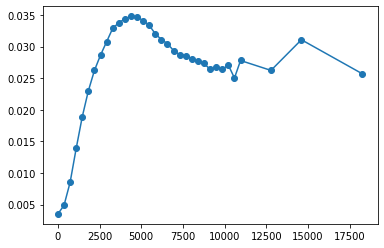

In [43]:
from datetime import date

fwd_curve =  ForwardRateCurve(libor_pillar_dates, fwd_result.x)

from matplotlib import pyplot as plt
plt.plot(fwd_curve.pillar_days, fwd_curve.pillar_rates, marker='o')
plt.show()
